In [1]:
import os
os.getcwd()

'/Users/avijitmajhi/Desktop/radar_nowcasting'

In [2]:
root_path = os.getcwd()

In [3]:
# Import Necessary Libraries
import numpy as np
from datetime import datetime
import pysteps
# Import utility functions from the repository (custom functions for data loading and other functionalities
import utility   

Pysteps configuration file found at: /opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/pystepsrc



In [4]:
# Define the data directory for the repository data
data_path = os.path.join(root_path, "Data")
# Define metadata files
metadata_X = utility.get_matadata(os.path.join(data_path, "radarmappatipo.tif"), type="X")
# metadata_C = utility.get_matadata(os.path.join(data_path, "civilpromap.tiff"), type="C")

/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


# Look for Event folder

In [5]:
# List all folders in the data path
folders = [folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]
folders

['UNICA_SG']

In [6]:
events = [event for event in os.listdir(os.path.join(data_path,'UNICA_SG')) if os.path.isdir(os.path.join(data_path, 'UNICA_SG', event))]
events

['20190320_0005',
 '20181014_0515',
 '20191111_0710',
 '20191222_0900',
 '20190412_1220',
 '20230513_1455',
 '20200120_1440',
 '20230302_0245',
 '20230129_2215',
 '20180505_1745',
 '20200911_1315',
 '20230520_2235']

In [7]:
events[3]

'20191222_0900'

# Check the number of file available for analysis

In [8]:
count_events = [utility.count_files(os.path.join(data_path, 'UNICA_SG', events[i]), 'png') for i in range(len(events))]
count_events

[39, 56, 38, 38, 36, 63, 55, 52, 39, 73, 45, 62]

# Load and Process X-Band Radar Data

In [9]:
# Define parameters for X-band radar data
data_source_X = 'UNICA_SG'
event_subdir = '20230520_2235'
f_ext_X = "png"
num_prev_files =9
timestep = 5

In [10]:
# Choose the date for particular subset
eventdates = [eventdate for eventdate in os.listdir(os.path.join(data_path,'UNICA_SG',event_subdir)) if os.path.isfile(os.path.join(data_path,'UNICA_SG', event_subdir,eventdate))]
eventdates

['20230520_1755.png',
 '20230520_1740.png',
 '20230520_2115.png',
 '20230520_1805.png',
 '20230520_1810.png',
 '20230520_2100.png',
 '20230520_2110.png',
 '20230520_1800.png',
 '20230520_1815.png',
 '20230520_2105.png',
 '20230520_1750.png',
 '20230520_1745.png',
 '20230520_1905.png',
 '20230520_2015.png',
 '20230520_2000.png',
 '20230520_1910.png',
 '20230520_1735.png',
 '20230520_2200.png',
 '20230520_2215.png',
 '20230520_2205.png',
 '20230520_1730.png',
 '20230520_2210.png',
 '20230520_1900.png',
 '20230520_2010.png',
 '20230520_2005.png',
 '20230520_1915.png',
 '20230520_2140.png',
 '20230520_1850.png',
 '20230520_1930.png',
 '20230520_2020.png',
 '20230520_2035.png',
 '20230520_1925.png',
 '20230520_1845.png',
 '20230520_2155.png',
 '20230520_2235.png',
 '20230520_2220.png',
 '20230520_2230.png',
 '20230520_2225.png',
 '20230520_2145.png',
 '20230520_1855.png',
 '20230520_1935.png',
 '20230520_2025.png',
 '20230520_2030.png',
 '20230520_1920.png',
 '20230520_1840.png',
 '20230520

In [11]:
date = datetime.strptime('20230520_1830.png', "%Y%m%d_%H%M.png")
date

datetime.datetime(2023, 5, 20, 18, 30)

In [12]:
# Load X-band radar data
R_dn, metadata_dn = utility.import_files_by_date(date, data_path, data_source_X,event_subdir, f_ext_X, metadata_X,num_prev_files,0,timestep=timestep)

In [13]:
# Verify results
print("Radar Data Shape:", R_dn.shape)
print("Timestamps:", metadata_dn["timestamps"])

Radar Data Shape: (10, 1024, 1024)
Timestamps: [datetime.datetime(2023, 5, 20, 17, 45)
 datetime.datetime(2023, 5, 20, 17, 50)
 datetime.datetime(2023, 5, 20, 17, 55)
 datetime.datetime(2023, 5, 20, 18, 0)
 datetime.datetime(2023, 5, 20, 18, 5)
 datetime.datetime(2023, 5, 20, 18, 10)
 datetime.datetime(2023, 5, 20, 18, 15)
 datetime.datetime(2023, 5, 20, 18, 20)
 datetime.datetime(2023, 5, 20, 18, 25)
 datetime.datetime(2023, 5, 20, 18, 30)]


# Noise Removal

In [14]:
# Noise removal using Watershed technique
R_dn_clean = np.empty_like(R_dn)
for t in range(R_dn.shape[0]):
    R_dn_clean[t, :, :] = utility.noise_remove(R_dn[t, :, :], type="Watershed")

# Data Transfromation

In [15]:
# Convert Digital Number to Reflectivity (dBZ)
R_dbz,metadata_dbz = utility.dn_to_dbz(R_dn_clean,metadata_dn)
# Convert to rain rate
R_R, metadata_R = pysteps.utils.conversion.to_rainrate(R_dbz, metadata_dbz)
# Log-transform the data
R_dbr, metadata_dbr = pysteps.utils.transformation.dB_transform(R_R, metadata_R, threshold=0.01, zerovalue=-15.0)

In [16]:
# Print metadata
from pprint import pprint
pprint(metadata_dbr)

{'accutime': 5,
 'cartesian_unit': 'm',
 'institution': 'UNICA',
 'product': 'png',
 'projection': '+proj=tmerc +lat_0=0 +lon_0=9 +k=0.9996 +x_0=1500000 +y_0=0 '
               '+ellps=intl '
               '+towgs84=-104.1,-49.1,-9.9,0.971,-2.917,0.714,-11.68 +units=m '
               '+no_defs +type=crs',
 'threshold': np.float64(-20.0),
 'timestamps': array([datetime.datetime(2023, 5, 20, 17, 45),
       datetime.datetime(2023, 5, 20, 17, 50),
       datetime.datetime(2023, 5, 20, 17, 55),
       datetime.datetime(2023, 5, 20, 18, 0),
       datetime.datetime(2023, 5, 20, 18, 5),
       datetime.datetime(2023, 5, 20, 18, 10),
       datetime.datetime(2023, 5, 20, 18, 15),
       datetime.datetime(2023, 5, 20, 18, 20),
       datetime.datetime(2023, 5, 20, 18, 25),
       datetime.datetime(2023, 5, 20, 18, 30)], dtype=object),
 'transform': 'dB',
 'unit': 'mm/h',
 'x1': 1478699.0,
 'x2': 1540139.0,
 'xpixelsize': 60.0,
 'y1': 4311475.0,
 'y2': 4372915.0,
 'yorigin': 'upper',
 'ypixel

# Rain Intensity GIF


/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
 

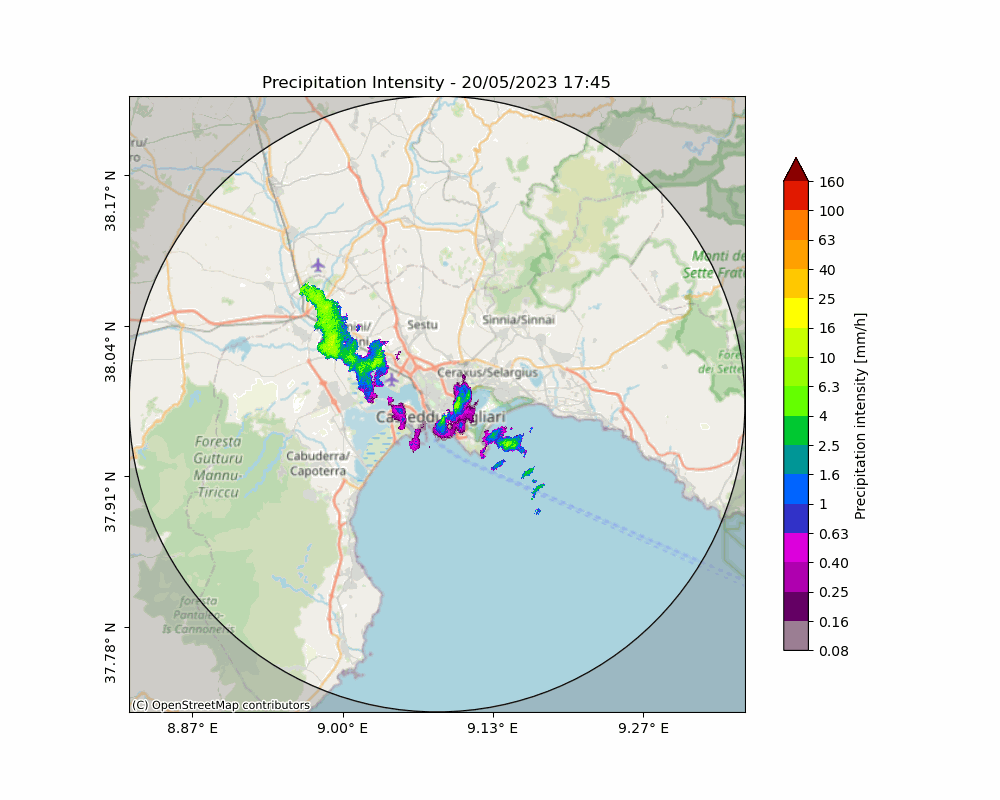

In [17]:
# Create a GIF that loops indefinitely
utility.create_gif(R_R, metadata_R,duration=5, units="mm/h", title="Precipitation Intensity",loop=True)

# Motion Field Estimation - Lucas Kanade (LK)
## It needs only 3 scans

In [18]:
# Estimate motion field using Lucas-Kanade optical flow
oflow_method = pysteps.motion.get_method("LK")
V1 = oflow_method(R_dbr[-10:, :, :])

# Visualization

/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(


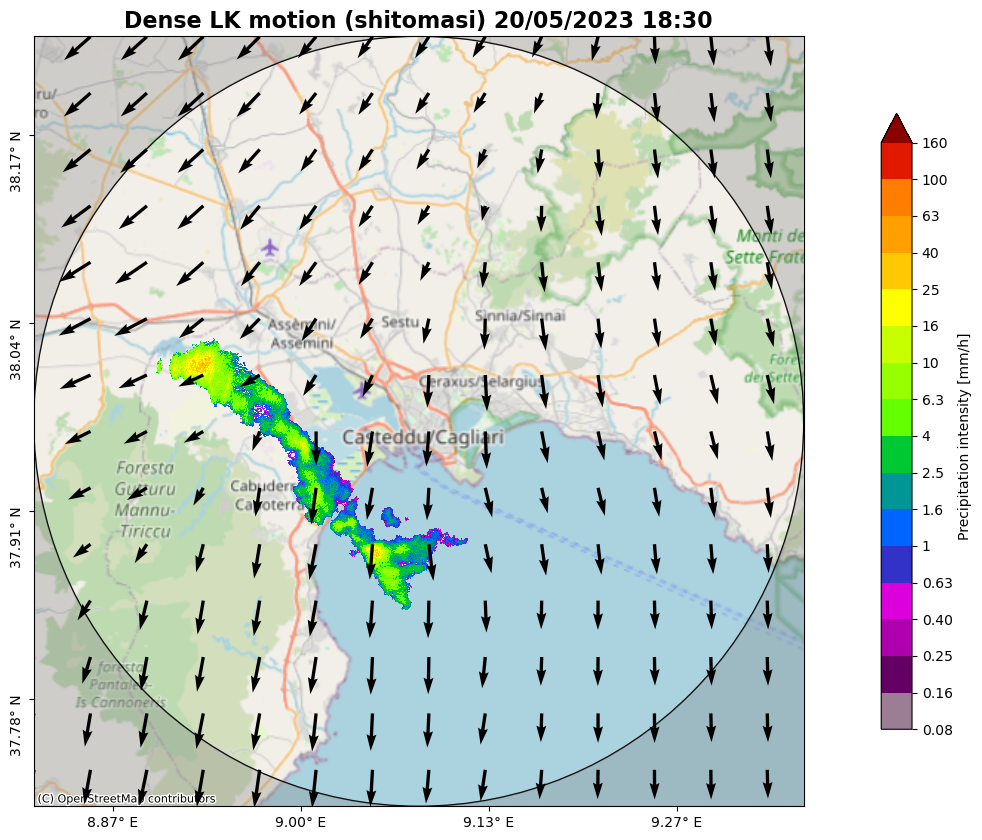

In [19]:
# Plot precipitation field and motion field
import matplotlib.pyplot as plt
from pysteps.visualization import plot_precip_field, quiver
fig, ax = plt.subplots(figsize=(20, 10))
# Precipitation field
plot_precip_field(
    R_R[-1, :, :], 
    ptype="intensity", 
    geodata=metadata_R, 
    units="mm/h", 
    ax=ax, 
    colorscale="pysteps"
)
ax.set_title(f"Dense LK motion (shitomasi) {metadata_R['timestamps'][-1].strftime('%d/%m/%Y %H:%M')}", fontsize=16,weight="bold")
# Motion field (quiver plot)
quiver(V1, geodata=metadata_R, step=75, ax=ax)
utility.plot_modification(ax,metadata_R)
plt.savefig("dense_lk_motion.png", dpi=300, bbox_inches="tight")
plt.show()

# Motion Field Estimation- Variational echo tracking (VET) Method
## It needs only  3 scans
### (it will take some time to run the algorithm)

Running VET algorithm
original image shape: (3, 1024, 1024)
padded image shape: (3, 1024, 1024)
padded template_image image shape: (3, 1024, 1024)

Number of sectors: 2,2
Sector Shape: (np.int64(512), np.int64(512))
Minimizing

residuals 4350498.157054875
smoothness_penalty 0.0
original image shape: (3, 1024, 1024)
padded image shape: (3, 1024, 1024)
padded template_image image shape: (3, 1024, 1024)

Number of sectors: 4,4
Sector Shape: (np.int64(256), np.int64(256))
Minimizing

residuals 4310163.336790535
smoothness_penalty 0.3618932781289255
original image shape: (3, 1024, 1024)
padded image shape: (3, 1024, 1024)
padded template_image image shape: (3, 1024, 1024)

Number of sectors: 16,16
Sector Shape: (np.int64(64), np.int64(64))
Minimizing

residuals 4125224.1745900726
smoothness_penalty 42.58793394068035
original image shape: (3, 1024, 1024)
padded image shape: (3, 1024, 1024)
padded template_image image shape: (3, 1024, 1024)

Number of sectors: 32,32
Sector Shape: (np.int64(32

/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(


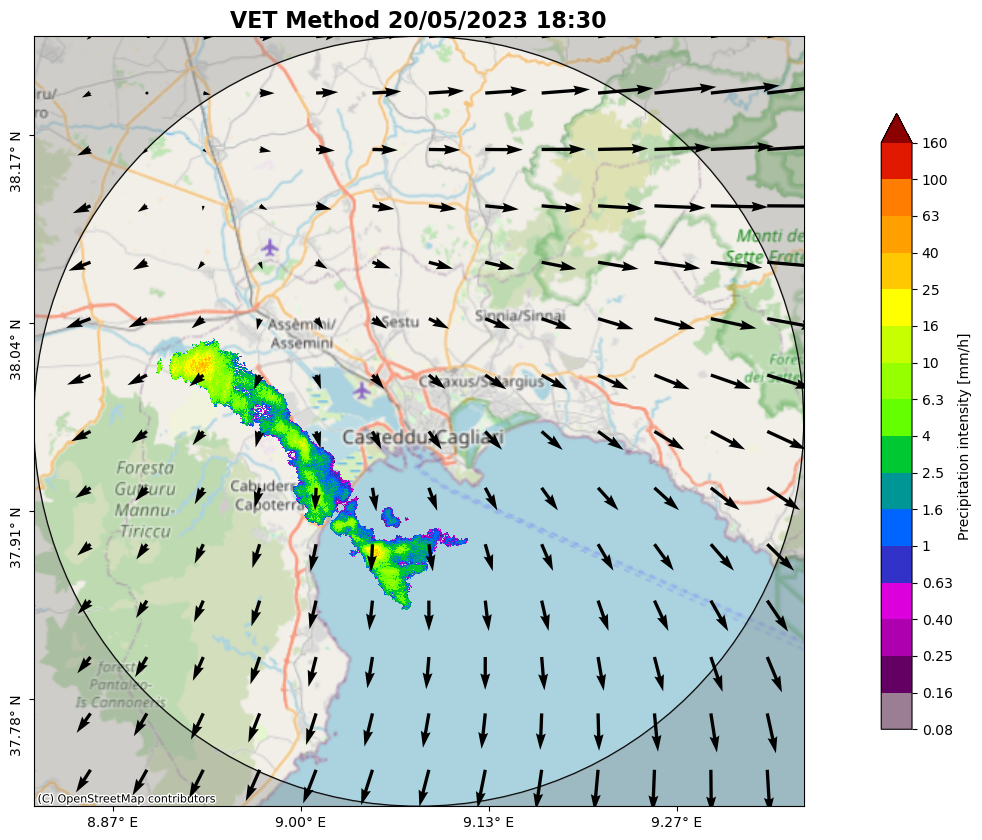

In [20]:
oflow_method = pysteps.motion.get_method("VET")
V2 = oflow_method(R_dbr[-3:, :, :])

# Plot the motion field
fig, ax = plt.subplots(figsize=(20, 10))
# Precipitation field
plot_precip_field(
    R_R[-1, :, :], 
    ptype="intensity", 
    geodata=metadata_R, 
    units="mm/h", 
    title="VET Method of "+ metadata_dbz['timestamps'][2].strftime("%d/%m/%Y %H:%M"), 
    ax=ax, 
    colorscale="pysteps"
)
ax.set_title(f"VET Method {metadata_R['timestamps'][-1].strftime('%d/%m/%Y %H:%M')}", fontsize=16,weight="bold")
quiver(V2, geodata=metadata_R, step=75,ax=ax)
utility.plot_modification(ax,metadata_R)
plt.savefig("vet_motion.png", dpi=300, bbox_inches="tight")
plt.show()

# Motion Field Estimation - Dynamic and adaptive radar tracking of storms (DARTS)
## It needs last 10 scans

In [21]:
oflow_method = pysteps.motion.get_method("DARTS")
R_dbr[~np.isfinite(R_dbr)] = metadata_dbr["zerovalue"]
V3 = oflow_method(R_dbr[-10:,:,:])  # needs longer training sequence

Computing the motion field with the DARTS method.
-----
DARTS
-----
Done in 0.96 seconds.f the reflectivity fields...
Done in 0.11 seconds.vector...
Done in 1.73 seconds.matrix...
Done in 0.28 seconds.systems...
--- 3.195172071456909 seconds ---


/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(


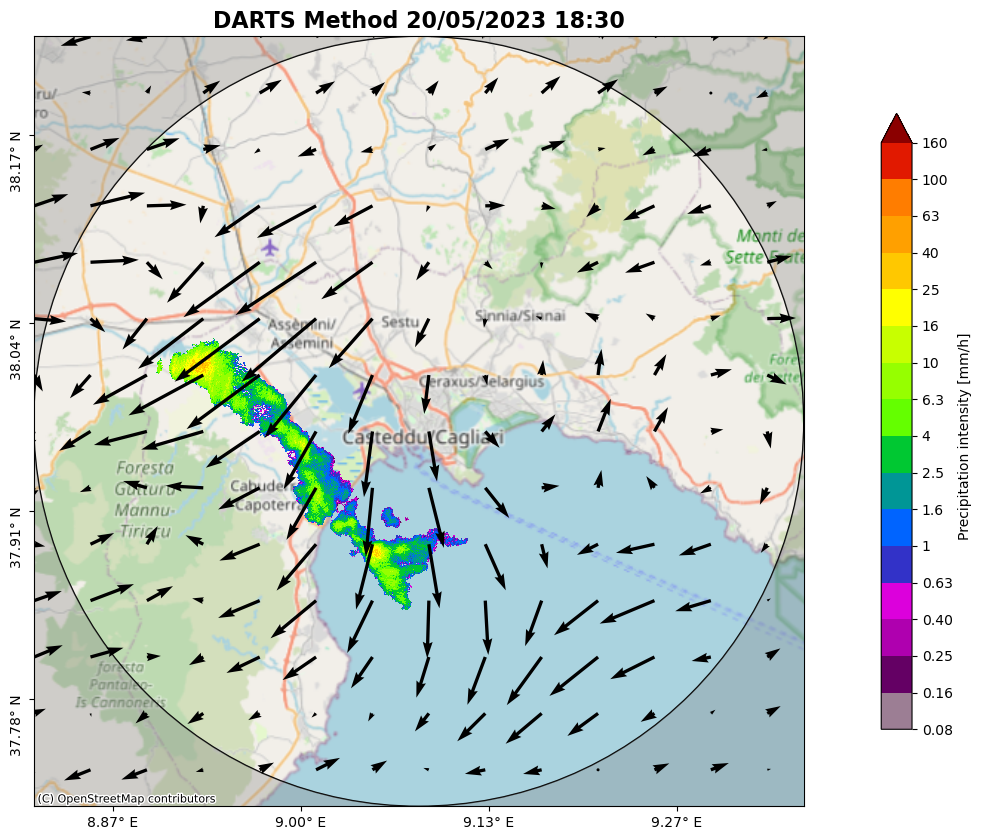

In [22]:
# Plot the motion field
fig, ax = plt.subplots(figsize=(20, 10))
# Precipitation field
plot_precip_field(
    R_R[-1, :, :], 
    ptype="intensity", 
    geodata=metadata_R, 
    units="mm/h", 
    ax=ax, 
    colorscale="pysteps"
)
ax.set_title(f"DARTS Method {metadata_R['timestamps'][-1].strftime('%d/%m/%Y %H:%M')}", fontsize=16,weight="bold")
quiver(V3, geodata=metadata_R, step=75,ax=ax)
utility.plot_modification(ax,metadata_R)
plt.savefig("darts_motion.png", dpi=300, bbox_inches="tight")
plt.show()

# Motion Field Estimation -  Anisotropic Diffusion Method 
## It need only last 2 scans

In [23]:
oflow_method = pysteps.motion.get_method("proesmans")
R_dbr[~np.isfinite(R_dbr)] = metadata_dbr["zerovalue"]
V4 = oflow_method(R_dbr[-2:, :, :])

/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(


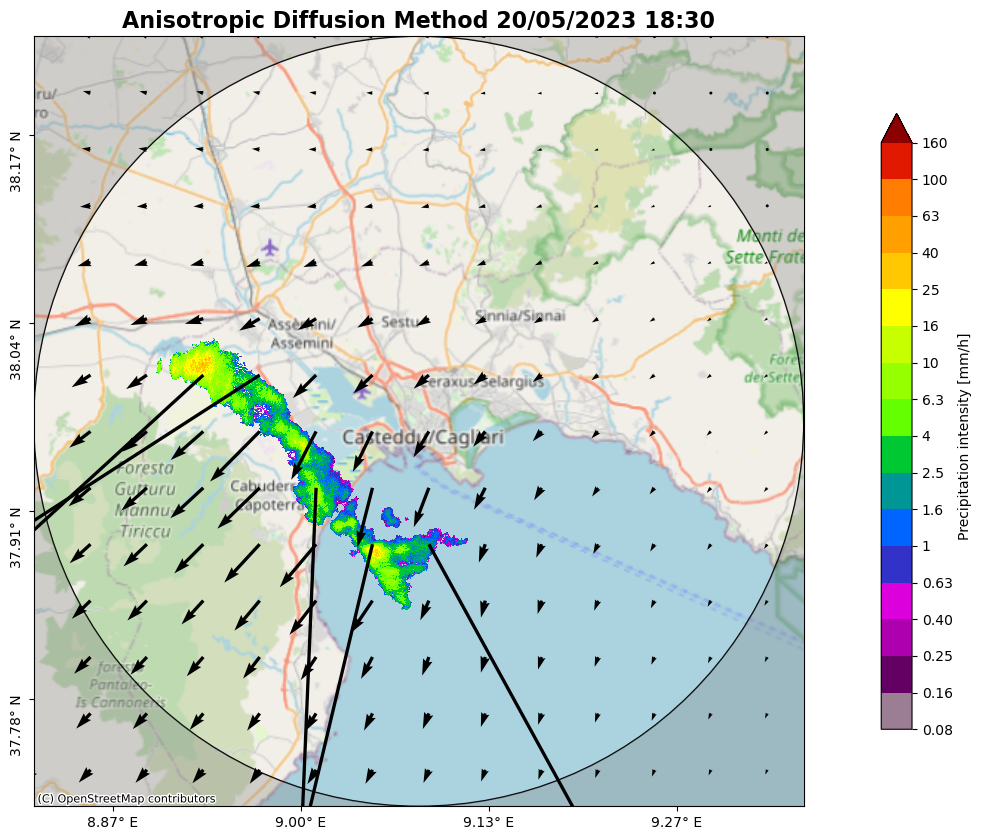

In [24]:
# Plot the motion field
fig, ax = plt.subplots(figsize=(20, 10))
# Precipitation field
plot_precip_field(
    R_R[-1, :, :], 
    ptype="intensity", 
    geodata=metadata_R, 
    units="mm/h",  
    ax=ax, 
    colorscale="pysteps"
)
ax.set_title(f"Anisotropic Diffusion Method {metadata_R['timestamps'][-1].strftime('%d/%m/%Y %H:%M')}", fontsize=16,weight="bold")
quiver(V4, geodata=metadata_R, step=75,ax=ax)
utility.plot_modification(ax,metadata_R)
plt.savefig("proesmans_motion.png", dpi=300, bbox_inches="tight")
plt.show()

# Combined all the plots for comparison

/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
/opt/miniconda3/envs/radar_nowcasting_env/lib/python3.12/site-packages/pysteps/visualization/utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
 

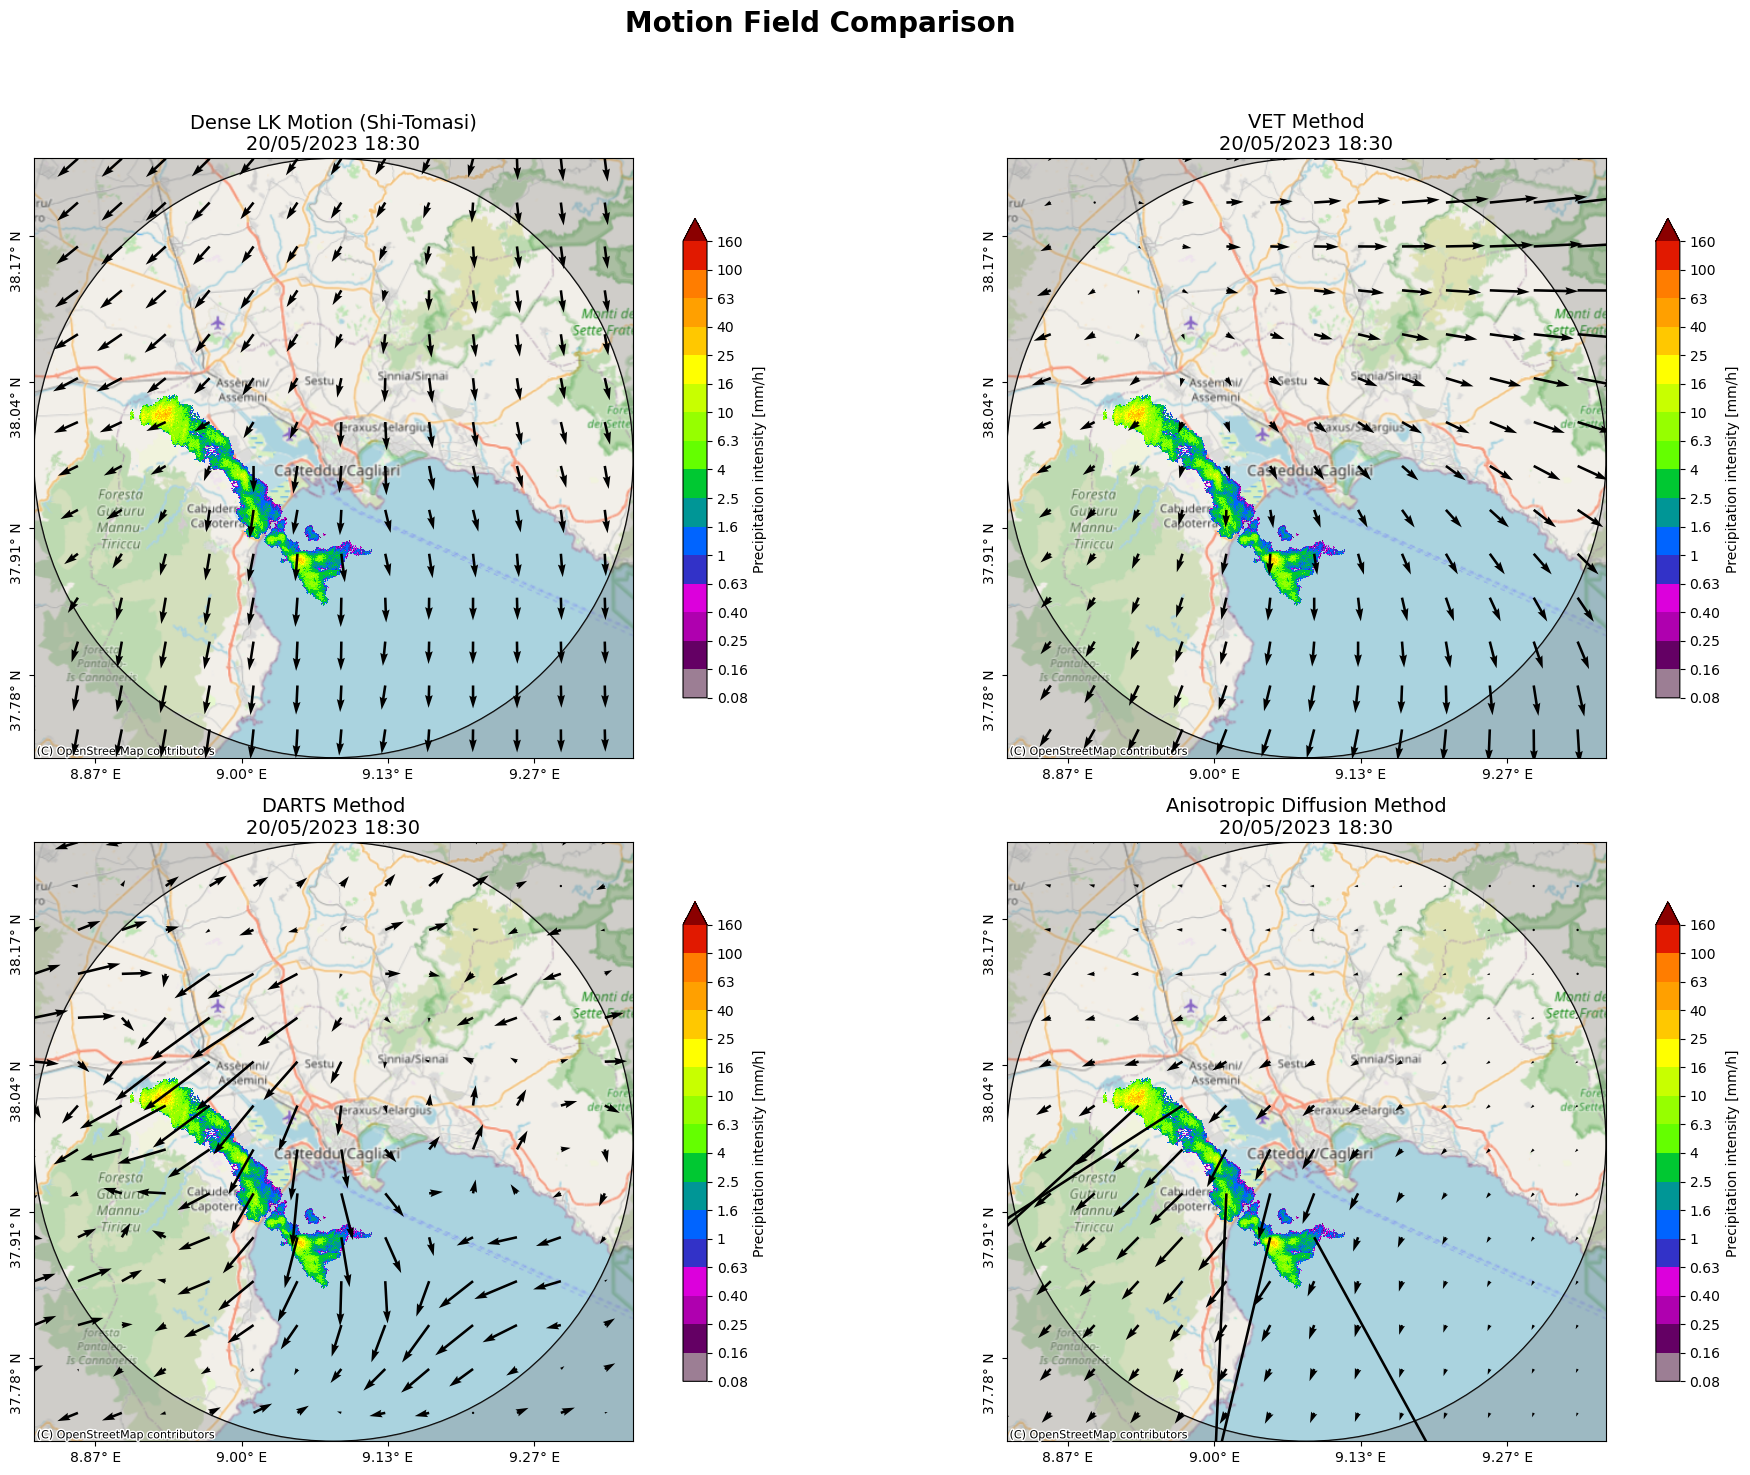

In [25]:
import matplotlib.pyplot as plt
# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle("Motion Field Comparison", fontsize=20, weight="bold")
# Plot 1: Dense LK Motion
plot_precip_field(
    R_R[-1, :, :], 
    ptype="intensity", 
    geodata=metadata_R, 
    units="mm/h", 
    ax=axes[0, 0], 
    colorscale="pysteps"
)
axes[0, 0].set_title(f"Dense LK Motion (Shi-Tomasi)\n{metadata_R['timestamps'][-1].strftime('%d/%m/%Y %H:%M')}", fontsize=14)
quiver(V1, geodata=metadata_R, step=75, ax=axes[0, 0])
utility.plot_modification(axes[0, 0], metadata_R)

# Plot 2: VET Method
plot_precip_field(
    R_R[-1, :, :], 
    ptype="intensity", 
    geodata=metadata_R, 
    units="mm/h", 
    ax=axes[0, 1], 
    colorscale="pysteps"
)
axes[0, 1].set_title(f"VET Method\n{metadata_R['timestamps'][-1].strftime('%d/%m/%Y %H:%M')}", fontsize=14)
quiver(V2, geodata=metadata_R, step=75, ax=axes[0, 1])
utility.plot_modification(axes[0, 1], metadata_R)

# Plot 3: DARTS Method
plot_precip_field(
    R_R[-1, :, :], 
    ptype="intensity", 
    geodata=metadata_R, 
    units="mm/h", 
    ax=axes[1, 0], 
    colorscale="pysteps"
)
axes[1, 0].set_title(f"DARTS Method\n{metadata_R['timestamps'][-1].strftime('%d/%m/%Y %H:%M')}", fontsize=14)
quiver(V3, geodata=metadata_R, step=75, ax=axes[1, 0])
utility.plot_modification(axes[1, 0], metadata_R)

# Plot 4: Anisotropic Diffusion Method
plot_precip_field(
    R_R[-1, :, :], 
    ptype="intensity", 
    geodata=metadata_R, 
    units="mm/h", 
    ax=axes[1, 1], 
    colorscale="pysteps"
)
axes[1, 1].set_title(f"Anisotropic Diffusion Method\n{metadata_R['timestamps'][-1].strftime('%d/%m/%Y %H:%M')}", fontsize=14)
quiver(V4, geodata=metadata_R, step=75, ax=axes[1, 1])
utility.plot_modification(axes[1, 1], metadata_R)
# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])
# Save the combined figure
plt.savefig("combined_motion_fields.png", dpi=300, bbox_inches="tight")
# Show the figure
plt.show()